In [1]:
from model import *
%load_ext autoreload
%autoreload 2
from casadi import *
N =30 # number of control intervals
Q = np.diag([120,
             100,
             100,
             1,
             1,
             1,
             1,
             7e-1,
             1.0,
             1.0,
             1e-2,
             1e-2,
             1e-2])
R = np.diag([1, 1, 1, 1])*0.01
mod = dynamics()
xdot = mod.xdot
x = mod.x
u = mod.u
F = Function('F', [x, u], [xdot])
f = 50
h = 1/f
x.shape

hover speed : 16.248810607359733


(13, 1)

In [2]:
x0_hat = SX.sym('x0', mod.nx, 1)
x_ref = SX.sym('x_ref', mod.nx, 1)
u_ref = SX.sym('u_ref', mod.nu, 1)
X = SX.sym('X', mod.nx, N+1)
U = SX.sym('U', mod.nu, N)
x_integrated = SX(mod.nx, N)

# x_integrated[:,0] = X[:,0]
for i in range(N):
    x_integrated[:, i] = X[:, i]

    for j in range(2):
        k1 = F(X[:,i], U[:,i])
        k2 = F(X[:,i] + 0.5*h * k1, U[:,i])
        k3 = F(X[:,i] + 0.5 *h* k2, U[:,i])
        k4 = F(X[:,i] + k3*h, U[:,i])
        x_integrated[:,i] = x_integrated[:, i] + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

integrator_fn = Function('integrator_fn', [X, U], [x_integrated])



In [3]:
cost = 0
state_dev = X - repmat(x_ref, 1, N+1)
state_dev[:, -1] *= 20 # Weight the last state more
cost += trace(state_dev.T @ Q @ state_dev)
control_dev = U 
cost += trace(control_dev.T @ R @ control_dev)
cost_fn = Function('cost_fn', [X, U], [cost]) # this cost Implements the Q-weighted L-2 norm of the state devviation, and the R-weighted L-2 norm of the control deviation. The last state is multiplied by a terminal cost weight.

In [4]:
J = cost_fn(X, U)

In [41]:
N = 20
# define model dynamics
terminal_weight = 20
mod = dynamics()
xdot = mod.xdot
x = mod.x
u = mod.u
f = Function('f', [x, u], [xdot]) # this function implements the dynamics of the quadcopter
# define optimisation variables
U = SX.sym('U', mod.nu, N)
X = SX.sym('X', mod.nx, N+1)

x0_hat = SX.sym('x0_hat', mod.nx, 1) # parameter that takes the initial state
x_ref = SX.sym('x_ref', mod.nx, 1) # parameter that takes the desired state
u_ref = SX.sym('u_ref', mod.nu, 1) # parameter that takes the desired input for the cost fn ( hover or max speed)

# define cost function
cost = 0
state_dev = X - repmat(x_ref, 1, N+1)
state_dev[:, -1] *= terminal_weight # Weight the last state more
cost += trace(state_dev.T @ Q @ state_dev)
control_dev = U - repmat(u_ref, 1, N)
# control_dev = U
cost += trace(control_dev.T @ R @ control_dev)
cost_fn = Function('cost_fn', [X, U], [cost]) # this cost Implements the Q-weighted L-2 norm of the state devviation, and the R-weighted L-2 norm of the control deviation. The last state is multiplied by a terminal cost weight.

# define integrator
M = 4 # RK4 steps per interval
DT = h*1  / M
x_integrated = SX(mod.nx, N)
for i in range(N):
    x_integrated[:, i] = X[:, i]
    for j in range(M):
        k1 = f(x_integrated[:, i], U[:, i])
        k2 = f(x_integrated[:, i] + DT / 2 * k1, U[:, i])
        k3 = f(x_integrated[:, i] + DT / 2 * k2, U[:, i])
        k4 = f(x_integrated[:, i] + DT * k3, U[:, i])
        x_integrated[:, i] +=  DT / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
#int
rk4 = Function('rk4', [X, U], [x_integrated]) # this function implements the RK4 integrator. The function integrated from each point Xk with control Uk to the next point Xk+1 starting with X0 and U0.
                                            #  the vector G contain Xk - x_integrated[k+1] 

initial_control_guess = [mod.hover_speed, mod.hover_speed, mod.hover_speed, mod.hover_speed]
# initial_control_guess = [22] * 4
initial_state_guess = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
x_min = [ -1, -1, 0, -inf, -inf, -inf,-inf, -3, -3, -3, -0.5, -0.5, -0.5]
x_max = [ 1, 1, 2, inf, inf, inf, inf, 3, 3, 3, 0.50, 0.5, 0.5]

u_min = [0, 0, 0, 0]
u_max = [22, 22, 22, 22]

w = []
w += horzsplit(X)
w += horzsplit(U)
lbw = [] 
lbw += [*[x_min ]* (N+1)]
lbw += [*[u_min ] * N]
ubw = []
ubw += [*[x_max ] * (N+1)]
ubw += [*[u_max ] * N  ]
w0 = []
w0 += [*[initial_state_guess ] * (N+1)]
w0 += [*[initial_control_guess ] * N]
g = []
lbg = []
ubg = []

integrated_state = rk4(X,U)
state_constraint = horzcat(x0_hat - X[:,0], integrated_state - X[:,1:])
# print(state_constraint.shape)
# integration_constraint = X[:, 1:] - integrator_fn(X,U)
# print(integration_constraint.shape)
# state_constraint = horzcat(state_constraint, integration_constraint)
# # state_constraint = horzcat(state_constraint, x_ref - X[:,-1])
# print(state_constraint.shape)
g += horzsplit(state_constraint)
g
# print(g.shape, "shape of g")
lbg = [0] * (mod.nx + mod.nx * N)
ubg = [0] * (mod.nx + mod.nx * N)
# len(g)
w = vertcat(*w)
w0 = vertcat(*w0)
lbw = vertcat(*lbw)
ubw = vertcat(*ubw)
g = vertcat(*g)
lbg = vertcat(*lbg)
ubg = vertcat(*ubg)
opts = {'ipopt': {'print_level': 5, 'max_iter': 1000, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6, }, "jit" :False, "jit_options" : {"flags" : "-O1"}}
prob = {'f': cost, 'x': w, 'g': g, 'p': vertcat(x0_hat, x_ref, u_ref)}
solver = nlpsol('solver', 'ipopt', prob, opts)
x_start = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
x_desired = [0.1, 0.1, 0.2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
u_hover = [mod.hover_speed, mod.hover_speed, mod.hover_speed, mod.hover_speed]
u_max = [22, 22, 22, 22]
res = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg, p=vertcat(x_start, x_desired, u_hover))
w_opt = res['x'].full().flatten()


hover speed : 16.248810607359733
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3313
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2113

Total number of variables............................:      353
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      269
                     variables with only upper bounds:        0
Total number of equality constraints.................:      273
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg

In [42]:
print(np.round(w_opt, 2))

[ 0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
 -0.000e+00 -0.000e+00  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00 -0.000e+00
  0.000e+00 -0.000e+00  0.000e+00  0.000e+00  1.000e-02 -5.000e-01
  5.000e-01 -5.000e-01  0.000e+00  0.000e+00  0.000e+00  1.000e+00
 -1.000e-02  1.000e-02 -1.000e-02  0.000e+00  0.000e+00 -0.000e+00
 -5.000e-01  5.000e-01 -5.000e-01  0.000e+00  0.000e+00  0.000e+00
  1.000e+00 -1.000e-02  1.000e-02 -1.000e-02  1.000e-02  1.000e-02
 -1.000e-02 -5.000e-01  5.000e-01 -5.000e-01  0.000e+00  0.000e+00
  0.000e+00  1.000e+00 -2.000e-02  2.000e-02 -2.000e-02  1.000e-02
  1.000e-02  1.000e-02 -5.000e-01  5.000e-01 -5.000e-01  0.000e+00
  0.000e+00  0.000e+00  1.000e+00 -2.000e-02  2.000e-02 -2.000e-02
  2.000e-02  2.000e-02  8.000e-02 -5.000e-01  5.000e-01 -5.000e-01
  0.000e+00  0.000e+00  0.000e+00  1.000e+00 -3.000e-02  3.000e-02
 -2.000e-02  3.000e-02  3.000e-02  2.200e-01 -5.000e-01  5.000

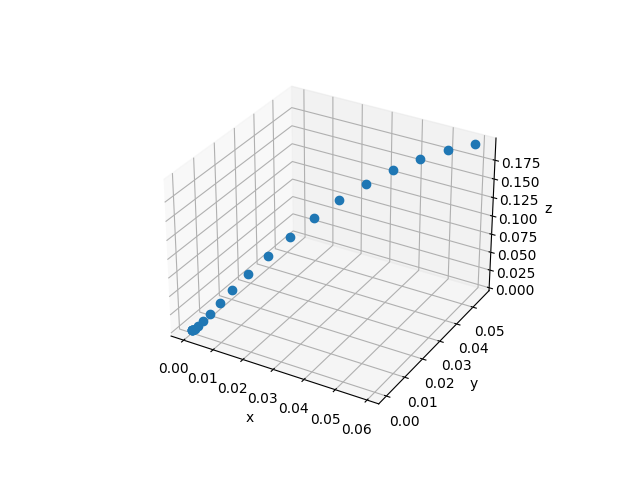

In [43]:
import matplotlib.pyplot as plt
%matplotlib widget

x_opt = w_opt[:mod.nx * (N+1)].reshape((N+1, mod.nx)).T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_opt[0, :], x_opt[1, :], x_opt[2, :], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [44]:
print("length of w0: ",w0.shape)
print("length of lbw: ",lbw.shape)
print("length of ubw: ",ubw.shape)
print("length of lbg: ",lbg.shape)
print("length of ubg: ",ubg.shape)
print("length of g: ",g.shape)

length of w0:  (353, 1)
length of lbw:  (353, 1)
length of ubw:  (353, 1)
length of lbg:  (273, 1)
length of ubg:  (273, 1)
length of g:  (273, 1)


In [45]:
prob = {'f': cost, 'x': vertcat(*w), 'g': vertcat(*g), 'p': vertcat(x0_hat, x_ref, u_ref)}
solver = nlpsol('solver', 'ipopt', prob)

Exception: CasADi matrices are not iterable by design.
                      Did you mean to iterate over m.nz, with m IM/DM/SX?
                      Did you mean to iterate over horzsplit(m,1)/vertsplit(m,1) with m IM/DM/SX/MX?
                      

In [ ]:
x_start = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
x_ref = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
u_ref = [mod.hover_speed, mod.hover_speed, mod.hover_speed, mod.hover_speed]
res = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg, p=vertcat(x_start, x_ref, u_ref))